In [342]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2, mutual_info_classif
from sklearn.metrics import *
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
import scipy.stats as stats
from scipy.stats import norm
from sklearn.svm import SVC
from sklearn.utils import resample # permet de faire du rééchantillonage
import warnings

In [343]:
data_train = pd.read_csv("sets/train.csv")
dataframe = data_train.copy()
data_test = pd.read_csv("sets/test.csv")
testset = data_test.copy()

pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings("ignore")

print(dataframe.columns)
print(testset.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')
Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')


# **Preprocessing & Modelisation**
## **1. Data Preprocessing**
- ### Feature Engineering : 

In [403]:
def feature_engineering(df):
    print("feature engineering")

    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df["pickup_month"] = df["pickup_datetime"].dt.month
    df["pickup_weekday"] = df["pickup_datetime"].dt.weekday
    df["pickup_day"] = df["pickup_datetime"].dt.day
    df["pickup_hour"] = df["pickup_datetime"].dt.hour
    df["pickup_dayofyear"] = df["pickup_datetime"].dt.dayofyear

    return df

- ### Encodage : 
    - pas de normalisation ou standardisation, ça génère des NaN car il y a trop peu de variance dans les variables continues

In [392]:
def encodage(df):
    print("Encodage")

    for col in df.select_dtypes(["object", "datetime"]):
        df[col] = df[col].astype("category").cat.codes
        df[col] = df[col].replace(-1, np.nan)

    return df

- ### Selection des variables : 

In [393]:
def select_var(df):
    return df

- ### Imputation : 

In [394]:
def imputation(df):
    print("imputation")

    df = df.drop(["id"], axis=1)
    df = df.drop("pickup_datetime", axis=1)
    df = df.drop("dropoff_datetime", axis=1)
    df = df.drop("store_and_fwd_flag", axis=1)

    outliers = df[df["trip_duration"] > 1e6]
    df = df.drop(outliers.index, axis=0)

    return df

- ### Transformation : 
    - trip_duration : log
    - pickup_longitude : cbrt
    - dropoff_longitude : cbrt

In [402]:
pt = PowerTransformer(method="yeo-johnson")
def transformation(df):
    print("transformation")

    df["trip_duration"] = np.log(df["trip_duration"])
    df[["pickup_longitude", "dropoff_longitude"]] = np.cbrt(df[["pickup_longitude", "dropoff_longitude"]])

    return df

- ### Train-Test split : 

In [396]:
trainset, testset = train_test_split(dataframe, test_size=0.2, random_state=0)

- ### Preprocessing : 

In [397]:
def preprocessing(df):
    df = feature_engineering(df)
    df = encodage(df)
    df = select_var(df)
    df = imputation(df)
    df = transformation(df)

    X = df.drop("trip_duration", axis=1)
    y = df["trip_duration"]

    return X, y

X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

feature engineering
Encodage
imputation
feature engineering
Encodage
imputation


- ### Transformation Inversion : 

In [398]:
def transformation_inversion(y_test, y_pred):
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)

    y_test = np.maximum(0, y_test) # valeur minimum de 0
    y_pred = np.maximum(0, y_pred)

    return y_test, y_pred

## **2. Modelisation**
- ### Model : 

In [399]:
model = make_pipeline(LGBMRegressor(force_col_wise=False, random_state=0))

- ### Evaluation : 
    - Score : 0.61
    - RMSLE : 0.48

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011662 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 1166912, number of used features: 11
[LightGBM] [Info] Start training from score 6.464350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 87518, number of used features: 11
[LightGBM] [Info] Start training from score 6.460401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

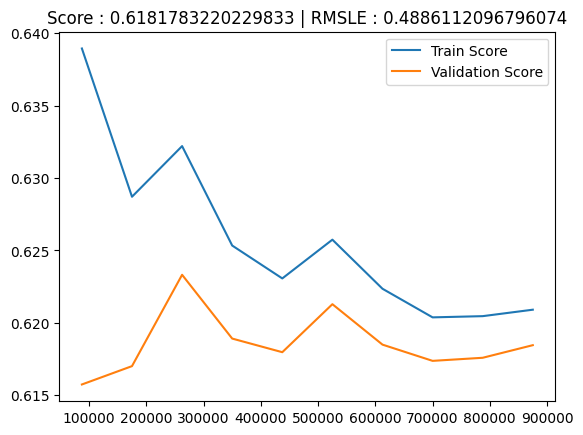

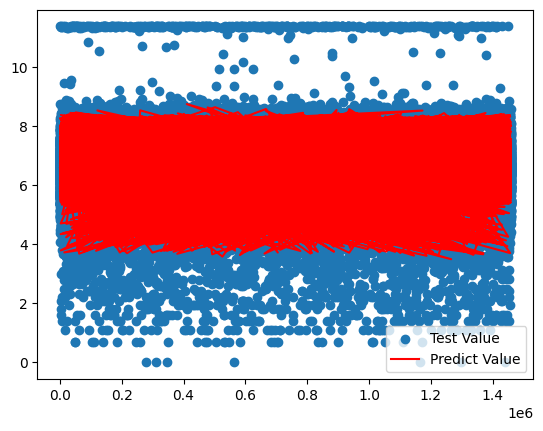

In [400]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_test_inv, y_pred_inv = transformation_inversion(y_test, y_pred)

    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, train_sizes=np.linspace(0.1, 1, 10))

    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label="Train Score")
    plt.plot(N, val_score.mean(axis=1), label="Validation Score")
    plt.title(f"Score : {model.score(X_train, y_train)} | RMSLE : {root_mean_squared_log_error(y_test_inv, y_pred_inv)}")
    plt.legend()

    plt.figure()
    plt.scatter(X_test.index, y_test, label="Test Value")
    plt.plot(X_test.index, y_pred, label="Predict Value", c="r")
    plt.legend()

evaluation(model)